<font size=5> __Scientific collaboration Network__: Kmeans and visualization </font>

It's known that different scientists have different styles of working, some enjoy mentoring many pupils while others prefer working with fewer. Moreover, even for a given scientist, their pattern of interaction within sceintific community might change during the course of their career. In this kernel, I try to see if I can classifying authors at NIPS'15 based on their collaboraion, number and type of publication.

Here is the outline:
    1. EDA
    2. Network measures
    3. KMeans clustering
    4. KMeans visualization using PCA for dimensionality reduction
    5. Network visualization, using plotly and networkx

In [1]:
import pandas as pd
import pickle as pk
import numpy as np
from scipy import sparse as sp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

title_font = {'size':'18', 'color':'black', 'verticalalignment':'bottom',  'fontstyle':'bold'} 
axis_font = { 'size':'14'}

In [8]:
#Read all the input files
aut_df = pd.read_csv('./nips_data/Authors.csv')
p_df = pd.read_csv('./nips_data/Papers.csv')
ap_df = pd.read_csv('./nips_data/PaperAuthors.csv')

In [9]:
print('Conference contain %s paper from %s author.'%(len(ap_df.PaperId.unique()), len(ap_df.AuthorId.unique())))

Conference contain 403 paper from 1078 author.


# Let's see what information we have about each paper?

In [10]:
p_df.head(2)

,Id,Title,EventType,PdfName,Abstract,PaperText
0,5677,Double or Nothing: Multiplicative Incentive Me...,Poster,5677-double-or-nothing-multiplicative-incentiv...,Crowdsourcing has gained immense popularity in...,Double or Nothing: Multiplicative\nIncentive M...
1,5941,Learning with Symmetric Label Noise: The Impor...,Spotlight,5941-learning-with-symmetric-label-noise-the-i...,Convex potential minimisation is the de facto ...,Learning with Symmetric Label Noise: The\nImpo...


The paper dataframe, includes information about different types of accepted papers at NIPS, what's the distribution:

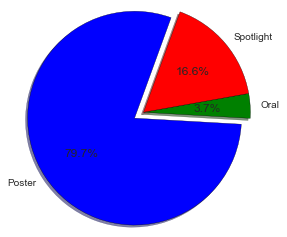

In [11]:
plt.figure(figsize=(4,4))
p_type= dict(p_df['EventType'].value_counts())
labels = list(p_type.keys())
sizes = list(p_type.values())

plt.pie(sizes, explode=(0.1, 0, 0), labels=labels,\
    autopct='%1.1f%%', shadow=True, startangle=70)
 
plt.axis('equal')
plt.show()

About 80% of the papers are in the form fo __Posters__.

 ## Number of publications per author

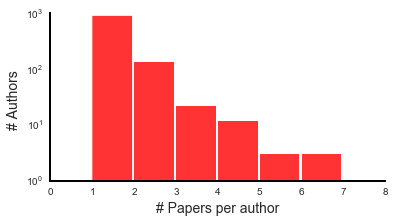

In [12]:
plt.figure(figsize=(6,3))
mpl.rcParams['axes.linewidth'] = 2 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'k'
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

aut_pap_cnt = dict(ap_df['AuthorId'].value_counts())

xmin = min(aut_pap_cnt.values())
xmax = max(aut_pap_cnt.values())
bins = (xmax-xmin)
plt.xlim(xmin-1, xmax+1)

ax = plt.hist(list(aut_pap_cnt.values()), bins=bins, log=1, width=0.95, color='r', edgecolor='none', alpha=0.8 );
# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]

plt.xlabel('# Papers per author', **axis_font)
plt.ylabel('# Authors ', **axis_font)

plt.grid(0)
plt.show()


To explore different patterns that scientist follow in this dataset, we will start by looking at the number and different kinds of publications per author. 

In [13]:
ptype_df = p_df[['Id', 'EventType']] 
ptype_df = ptype_df.join(pd.get_dummies(ptype_df['EventType']), how='outer')
ap_df = ap_df.merge(ptype_df.rename(columns={'Id':'PaperId'}), on='PaperId').drop('Id', axis =1)

In [14]:
nip_df = ap_df.copy()
nip_df.drop('EventType', axis=1, inplace=True)

In [15]:
nip_df = nip_df.groupby('AuthorId').sum().reset_index()
nip_df['Total_Publications'] = nip_df['Oral']+nip_df['Poster']+nip_df['Spotlight']

for i in 'Oral','Poster', 'Spotlight':
    nip_df[i+'_ratio'] = nip_df[i]/nip_df['Total_Publications']

In [16]:
''' Now the dataframe looks like:'''
nip_df.head(2)

,AuthorId,PaperId,Oral,Poster,Spotlight,Total_Publications,Oral_ratio,Poster_ratio,Spotlight_ratio
0,178,23017,0.0,2.0,2.0,4.0,0.0,0.500000,0.500000
1,200,17494,0.0,2.0,1.0,3.0,0.0,0.666667,0.333333


# Network analysis

    1. To construct the author-author interaction network, we start by the bipartite graph of author-papers.

In [17]:
''' First need to map both author and paper ids to start
    from zero so that we can store them in a numpy array. '''

int_pid = dict(enumerate(list(ap_df.PaperId.unique())))
int_aid = dict(enumerate(list(ap_df.AuthorId.unique())))

pid_intid = {v:k for k,v in int_pid.items()}
aid_intid = {v:k for k,v in int_aid.items()}

In [18]:
ap_tuples = list(zip(ap_df.AuthorId, ap_df.PaperId))
ap_int_tups =  [(aid_intid[i[0]], pid_intid[i[1]]) for i in ap_tuples]
''' AP: matrix of author-paper, AP[i, j]=1 indicates that author i has published paper j '''
AP = sp.csc_matrix((np.ones(len(ap_int_tups)), zip(*ap_int_tups)))

In [19]:
''' AA: the author-author matrix, 
    AA[i, j]=1 indicates that author i has published a paper with author j '''

AA = AP.dot(AP.T)

In [20]:
print("Only {:.4%} of potential author-author connections exists.".format(0.01*len(AA.nonzero()[1])/float(AA.shape[0]**2)))

Only 0.0039% of potential author-author connections exists.


    2. Converting the numpy 2d array to network, using python's Networkx module as follow:

In [21]:
import networkx as nx

'Remove self-loops'
AA = np.array(AA - np.diag(AA.diagonal()))

'Weighted graph'
G = nx.from_numpy_matrix(AA, parallel_edges=True)


    3. Compute network centrality measures to add to authors dataframe ...

In [22]:
'''number of co-authors per member '''
node_deg = nx.degree(G) 

'''normalized number of co-authors ( with what fraction of NIPS authors he wrote a paper) '''
deg_cent = nx.degree_centrality(G) 

'''fraction of the number of times the author appears on the path connecting two other authors '''
bet_cent = nx.betweenness_centrality(G)

In [23]:
nip_df['Degree'] = nip_df['AuthorId'].apply(lambda l: node_deg[aid_intid.get(l)])
nip_df['Deg_Cent'] = nip_df['AuthorId'].apply(lambda l: deg_cent[aid_intid.get(l)])
nip_df['Betweenness'] = nip_df['AuthorId'].apply(lambda l: bet_cent.get(aid_intid.get(l)))

In [24]:
# Rescaling the betweenness measure
nip_df['Bet_Norm'] = nip_df['Betweenness'].apply(lambda l: np.arcsinh(l+1e-6))

In [25]:
nip_df.head(2)

,AuthorId,PaperId,Oral,Poster,Spotlight,Total_Publications,Oral_ratio,Poster_ratio,Spotlight_ratio,Degree,Deg_Cent,Betweenness,Bet_Norm
0,178,23017,0.0,2.0,2.0,4.0,0.0,0.500000,0.500000,13,0.012071,0.000104,0.000105
1,200,17494,0.0,2.0,1.0,3.0,0.0,0.666667,0.333333,6,0.005571,0.000290,0.000291


# Study the correlation of citation and other features

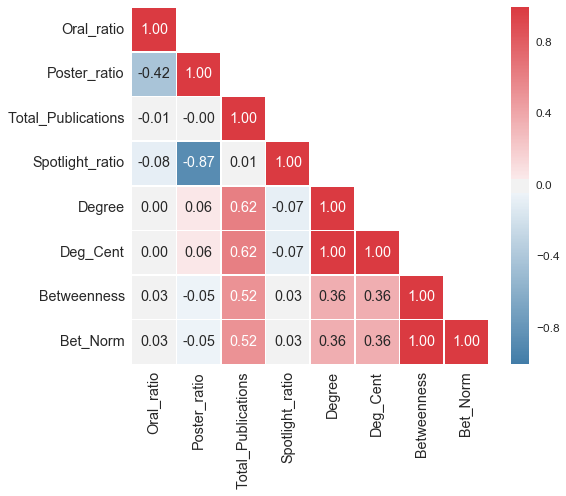

In [26]:
import seaborn as sns
sns.set(style="white", font_scale=1.2)

cols = ['Oral_ratio', 'Poster_ratio', 'Total_Publications',
       'Spotlight_ratio', 'Degree', 'Deg_Cent', 'Betweenness', 'Bet_Norm']
corr_z = nip_df[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_z, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

f, ax = plt.subplots(figsize=(8, 8))

cmap = sns.diverging_palette(240, 11, as_cmap=True)

g = sns.heatmap(corr_z, mask=mask, cmap=cmap, vmax=1,
            square=True, annot=True, fmt = '.2f',
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax, )

locs, labels = plt.yticks();
g.set_yticklabels(labels, rotation=0, size='medium');
locs, labels = plt.xticks();
g.set_xticklabels(labels, rotation=90, size='medium');

What do we see?
    1. Strong positive correlation between all the centrality measures and the total number of publications. This seems intuitve, since the more publications you have, there are more chance for collaboration ( thus higher degree) and also more likely to be the common co-author of two other scientists.
    
    2. Both **Spotlight** and **Oral** have a negative correlation with the number of **Posters**. The more poster one has (mostly presented by Junior students), its less likely that they have a spotlight/oral too. 

# Classifying authors:
    The above observation, of negative correlation between the number posters and spotlight/Oral, suggests different trends of behavior amongst scientists publishing at NIPS. Next we try to see if we can seperate authors into different classes.

In [27]:
from sklearn.preprocessing import StandardScaler

nip_df['NonPos_ratio'] = nip_df['Oral_ratio']+nip_df['Spotlight_ratio']

X = nip_df[['Oral','Poster', 'Spotlight', 'Total_Publications',\
            'Oral_ratio', 'Poster_ratio', 'Spotlight_ratio', 'NonPos_ratio',\
            'Degree', 'Deg_Cent', 'Betweenness', 'Bet_Norm']]

stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)

# K-means
** Inertia vs. # of clusters**


Since we don't know apriori how many classes of athors we should expect (unsupervised classification), we need to find a way to get an estimate. Here I use Inertia vs. # of clusters

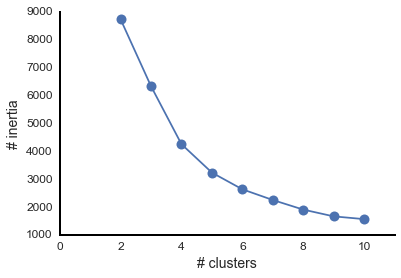

In [28]:
%matplotlib inline
mpl.rcParams['axes.linewidth'] = 2 
mpl.rcParams['axes.edgecolor'] = 'k'
from sklearn.cluster import KMeans
fig = plt.figure(figsize=(6,4))

x1 = []
y1 = []
for n in range(2,11):
    km = KMeans(n_clusters=n, random_state=7)
    km.fit(X_std)
    x1.append(n)
    y1.append(km.inertia_)
    
ax = plt.plot(x1, y1, marker='o', markersize=10);

plt.xlim([0,11])
plt.xlabel('# clusters', **axis_font)
plt.ylabel('# inertia', **axis_font)
plt.show()

In [29]:
''' Using the elbow method, we choose 4 clusters for our classifier. '''
n_cluster = 4

# Classification visualization:
 
In order to visualize different classes, we need to reduce the dimension from 12 to either 2, 3. I use PCA to find the number of components that are sufficeint to explain the variation in the data. 

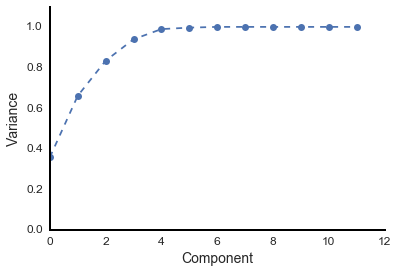

In [30]:
from sklearn.decomposition import PCA

total_pca = PCA().fit(X_std)

ax = plt.plot(total_pca.explained_variance_ratio_.cumsum(), '--o')

plt.xlabel('Component', **axis_font)
plt.ylabel('Variance', **axis_font)
plt.ylim([0,1.1])
plt.show()

In [31]:
''' From the plot above 5 components seems to be enough to explain the variation.'''
n_pca = 5

In [32]:
# from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = PCA(n_components=n_pca)
X_pca = sklearn_pca.fit_transform(X_std)

print(X_pca.shape)

(1078, 5)


In [33]:
print('explained variance ratio (first %s components): %s'
      %(n_pca, str(sklearn_pca.explained_variance_ratio_.cumsum()[n_pca-1])))

explained variance ratio (first 5 components): 0.989131678577


In [34]:
X2 = nip_df[['Oral_ratio', 'Poster_ratio', 'Spotlight_ratio', 'NonPos_ratio',\
            'Total_Publications', 'Degree','Deg_Cent', 'Bet_Norm']]

km = KMeans(n_clusters=n_cluster, n_init=10, random_state=7)
# km.fit(X2_std);
km.fit(X_pca);

X2.is_copy = False
X2['Cluster'] = km.labels_
X2['Cluster'] = X2['Cluster'].astype(np.int0)

cls_means = X2.groupby('Cluster').mean()
cls_means

,Oral_ratio,Poster_ratio,Spotlight_ratio,NonPos_ratio,Total_Publications,Degree,Deg_Cent,Bet_Norm
Cluster,,,,,,,,
0,0.000000,0.998770,0.001230,0.001230,1.113161,3.079951,0.002860,0.000003
1,0.000000,0.103578,0.896422,0.896422,1.220339,2.807910,0.002607,0.000006
2,0.051894,0.752597,0.195509,0.247403,3.363636,8.113636,0.007534,0.000251
3,0.909091,0.079545,0.011364,0.920455,1.181818,3.181818,0.002954,0.000005


## We observe 3 different patterns of behaviors:
    
    1. 'Junior students': First cluster includes authors who mostly present a poster, corresponding to PhD students. They're connected to other scientist(mentors and colleagues), explained by their degree>1, they are rarely the bridge that connects two not-connected scientists, demonstrated as the small betweenness centrality. 
    
    2. 'Senior Grad': Authors in the 2nd cluster, has a high fraction of Spotlight yet they have published posters too. I'm speculating these to be the senior gradudate students in the field, they publish fewer number of papers and most of them are spotlight presentation.
    
    3. 'Junior Faculty': Authors in this cluser, are the most connected ones. They have a high fraction of posters yet they've published Spotlight and oral papers too. We associate these group to junior faculty, they produce a relatively hight impact research, while mainting a large connectivity to others (mentees and collaborators). They also have the highest betweenness centrality.
    
    4. 'Senior Faculty': This last group has only spotlight presentations and the smallest fraction for poster presentations. Suggesting to be, senior faculties who don't have very many junior (poster writing) collaborators.

** Classifying authors:**  
The above observation, of negative correlation between the number posters and spotlight/Oral, suggests different trends of behavior amongst scientists publishing at NIPS. Next we try to see if we can seperate authors into different classes.

In [35]:
cls_name ={0: 'Junior students', 1: 'Senior Grad', 2: 'Junior Faculty', 3: 'Senior Faculty'}

In [36]:
X2['Cluster_Names'] = X2['Cluster'].apply(lambda l: cls_name[l])

In [37]:
y = X2['Cluster']
target_names = X2['Cluster_Names'].unique()

We can look at the distribution of different features per cluster.

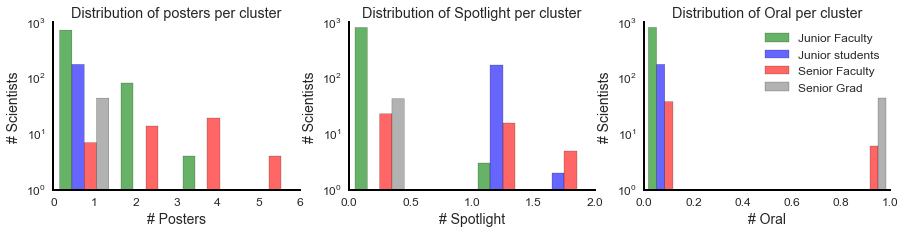

In [38]:
X.is_copy = False
X['Cluster'] = X2['Cluster']
X['Cluster_Names'] = X2['Cluster_Names']

fig = plt.figure(figsize=(15,3))
plt.subplot(131)
vals = {}
xmin, xmax = X['Poster'].min(), X['Poster'].max()
bins = np.linspace(xmin, xmax, 5)

for i in range(n_cluster):
    vals[i] = X[X['Cluster']==i]['Poster'].tolist()
    
plt.hist([vals[i] for i in range(n_cluster)], bins, alpha = 0.6, log=1,\
     color=['g', 'b', 'r', 'grey'], label= [t for t in target_names])
plt.xlabel('# Posters', **axis_font)
plt.ylabel('# Scientists', **axis_font)
plt.title('Distribution of posters per cluster')
plt.grid(0)
plt.subplot(132)

vals = {}
xmin, xmax = X['Spotlight'].min(), X['Spotlight'].max()
bins = np.linspace(xmin, xmax, 5)

for i in range(n_cluster):
    vals[i] = X[X['Cluster']==i]['Spotlight'].tolist()
    
plt.hist([vals[i] for i in range(n_cluster)], bins, alpha = 0.6, log=1,\
     color=['g', 'b', 'r', 'grey'])#, label=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

plt.xlabel('# Spotlight', **axis_font)
plt.ylabel('# Scientists', **axis_font)
plt.title('Distribution of Spotlight per cluster')
plt.grid(0)

plt.subplot(133)

vals = {}
xmin, xmax = X['Oral'].min(), X['Oral'].max()
bins = np.linspace(xmin, xmax, 7)

for i in range(n_cluster):
    vals[i] = X[X['Cluster']==i]['Oral'].tolist()
    
plt.hist([vals[i] for i in range(n_cluster)], bins, alpha = 0.6, log=1,\
     color=['g', 'b', 'r', 'grey'], label= [t for t in target_names])

plt.xlabel('# Oral', **axis_font)
plt.ylabel('# Scientists', **axis_font)
plt.title('Distribution of Oral per cluster')


plt.legend(loc='best');
plt.grid(0)
plt.show()


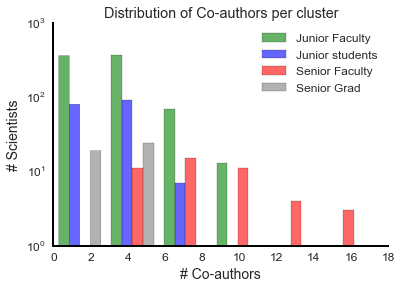

In [39]:
fig = plt.figure(figsize=(6,4))

vals = {}
xmin, xmax = X['Degree'].min(), X['Degree'].max()
bins = np.linspace(xmin, xmax, 7)
colors=['g', 'b', 'r']

for i in range(n_cluster):
    vals[i] = X[X['Cluster']==i]['Degree'].tolist()

plt.hist([vals[i] for i in range(n_cluster)], bins, alpha = 0.6, log=1,\
     color=['g', 'b', 'r', 'grey'], label= [t for t in target_names])
plt.legend(loc='best');
plt.xlabel('# Co-authors', **axis_font)
plt.ylabel('# Scientists', **axis_font)
plt.title('Distribution of Co-authors per cluster')


plt.grid(0)

### PCA for dimensionality reduction and visualiztion:

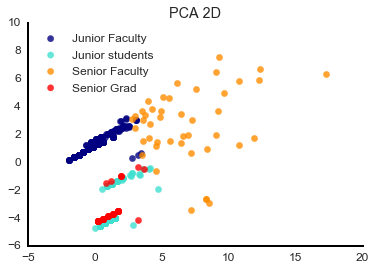

In [40]:
%matplotlib inline

plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'red']

for color, i, target_name in zip(colors, range(n_cluster), target_names):
    plt.scatter(X_pca[y == i, 1], X_pca[y == i, 0], color=color, alpha=.8, s=40,
                label=target_name)
plt.legend(loc=2, shadow=False, scatterpoints=1)
plt.grid(0)
plt.title('PCA 2D')
plt.show()

Using only 2 components,  fails to split datapoints. Next we try 3D.

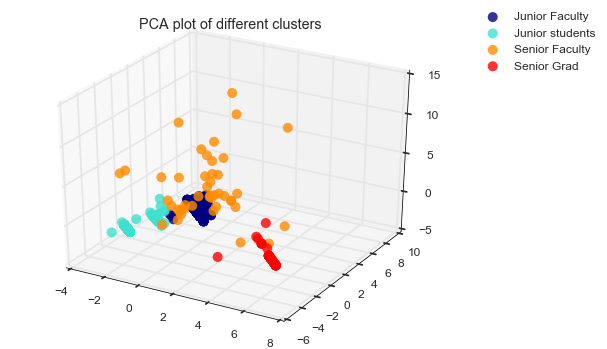

In [41]:
# %matplotlib notebook 
# %matplotlib notebook # enable to get the interactive graph
# %matplotlib inline  # disable to get the interactive graph
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = ['navy', 'turquoise', 'darkorange', 'red']

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111, projection='3d')
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_pca[y == i, 2], X_pca[y == i, 0], X_pca[y == i, 3], c=color, alpha=.8, lw=0,
                label=target_name, s=100)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('PCA plot of different clusters')
plt.show()

Using 3 of the principle components, we see a more clear seperatation of authors' classes.

### Network visualiztion:

    Lastly we look at the network of co-authorship at NIPS'15, where each node represent one author who wrote a paper at NIPS 2015, and two nodes are connected, if their corresponding authors, have wrote a paper together.
    
        1. Color code authors by their classes.
        2. Size of node, indicated the number of co-authorships.
        3. Hovering over nodes, display author names.

In [42]:
print(G.number_of_edges(), G.number_of_nodes(), nx.density(G)) 

(1749, 1078, 0.003012904326075834)


Network is very sparse, since the larger fraction of authors only publish poseters, next we remove those. This allows the network to be visually more informative.

In [43]:
''' choosing subnodes'''
nip_sub = nip_df[(nip_df['Oral'] + nip_df['Spotlight'])>0 ]
sub_authors =nip_sub['AuthorId'].unique().tolist()

''' build network of subnodes'''
K = G.subgraph([aid_intid[i] for i in sub_authors])
print(K.number_of_edges(), K.number_of_nodes())

(331, 248)


In [44]:
nip_df['Cluster'] = X2['Cluster']
author_cls = dict(zip(nip_df.AuthorId, nip_df.Cluster))

In [45]:
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(K)

In [51]:
labels=[]
group=[]
for node in K.nodes():
    labels.append(int_aid[node])
    group.append(author_cls[int_aid[node]])
    
''' Manually assign colors to each group'''
grp_clrs = {0:'grey', 1:'g', 2:'r', 3:'b'}

In [52]:
''' Hovering over nodes, display author names 
    Mapping author IDs to names '''
aid_name = dict(zip(aut_df.Id, aut_df.Name))

In [53]:
import plotly.plotly as py
from plotly.graph_objs import *
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=1.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in K.edges(data=True):
    
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='Jet',
        color=group,
        size=[],
        colorbar=dict(
            title='Class',
            tickvals = [i for i in range(4)],
            ticktext = [cls_name[i] for i in range(4)],
            ticks = 'outside'
        ),
        line=dict(width=1)))

for node in K.nodes():
    x, y = pos[node]#G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)


In [54]:
node_deg = K.degree()
node_trace['marker']['size'] =[]
node_trace['marker']['color'] =[]
node_trace['text'] =[]
for node in K.nodes():
    node_trace['marker']['size'].append(4*(node_deg[node]))
    name = aid_name.get(int_aid[node])
    node_info = '# of connections: %s <br />AuthorID: %s'%(str(node_deg[node]), str(name))

    node_trace['text'].append(node_info)
    node_trace['marker']['color'].append(author_cls[int_aid[node]])

In [55]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Collaboration Network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=10,l=15,r=5,t=40),
                annotations=[ dict(
                    text=labels,
                    showarrow=False)],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='collaboration_network_vis')

# To see the final plot go to this link:
http://nbviewer.jupyter.org/github/ykhorram/nips2015_topic_network_analysis/blob/master/nips_collaboration_network.ipynb
    

## What's next:
    I am interested in looking at the number of citations and the max citations recieved by each author. 
    
Hope you've enjoyed this network presentation. Please let me know if you have any questions/suggestions.
    